In [2]:
# automatically update imports
%load_ext autoreload
%autoreload 2

# For graphs
%matplotlib inline

# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import extract_uses.parameters as parameters
import extract_uses.utils as utils

# City to download: Grenoble
city_country = "grenoble_france"
citiesFolder = 'cities/'
# Population count file
popu_count_file = "/home/lgervasoni/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-2000/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2000.tif"

# Get the required cities shapefile
utils.getCityShapefile(citiesFolder, [ city_country ])

# Set input files
parameters.setInputFiles(citiesFolder, city_country, popu_count_file, numberOfCuts = 4)

('Existing shapefile for', 'grenoble_france')


In [3]:
import extract_uses.main

# Note: If city_country.h5 exists in hdfs store, avoid extracting uses
extract_uses.main.process()

('Folder already exists. Assumption: Already processed. Only mapping categories and exiting.', 'cities/grenoble_france/')
Complete processing: --- 0.405209636688 minutes ---


In [5]:
"""
import scatterdness.cluster_pts as cluster_pts

city_ref = 'grenoble'
activities_shp = city_ref+"/full_activities.shp"
residential_shp = city_ref+"/full_residential.shp"

cluster_pts.cluster_dbscan(residential_shp)
cluster_pts.cluster_kmeans(residential_shp)
cluster_pts.cluster_meanshift(residential_shp)
"""

'\nimport scatterdness.cluster_pts as cluster_pts\n\ncity_ref = \'grenoble\'\nactivities_shp = city_ref+"/full_activities.shp"\nresidential_shp = city_ref+"/full_residential.shp"\n\ncluster_pts.cluster_dbscan(residential_shp)\ncluster_pts.cluster_kmeans(residential_shp)\ncluster_pts.cluster_meanshift(residential_shp)\n'

In [7]:
import loaders
import extract_uses.utils as utils

uses_shp = citiesFolder+city_country+"/full_uses.shp"
bbox = utils.getBoundingBox(uses_shp)

geo_graph = loaders.load_graph(city_country, bbox)
pois_df = loaders.load_pois(city_country, uses_shp)
centrality_df = loaders.load_graph_centrality(city_country, geo_graph)
kde_df = loaders.load_graph_kde(city_country, geo_graph, pois_df)

('Bounding box:', [45.113017726416615, 5.573125356566398, 45.243980680751875, 5.9029513504478865])
Querying locally for `['nodes', 'edges']`
Found ['nodes', 'edges'] stored locally
Querying locally for `['pois']`
Found ['pois'] stored locally
Querying locally for `['graph_centrality']`
Found ['graph_centrality'] stored locally
Querying locally for `['graph_kde']`
Found ['graph_kde'] stored locally


In [63]:
pois_df.head()

category   key        lat       lon                value
id                                                                 
1920271581     shop  shop  45.125433  5.576436  interior_decoration
1920271584     shop  shop  45.125623  5.576625          supermarket
2174187162     shop  shop  45.130817  5.581009               cheese
871753987      shop  shop  45.130947  5.581115          convenience
2174186970     shop  shop  45.127480  5.589134               sports

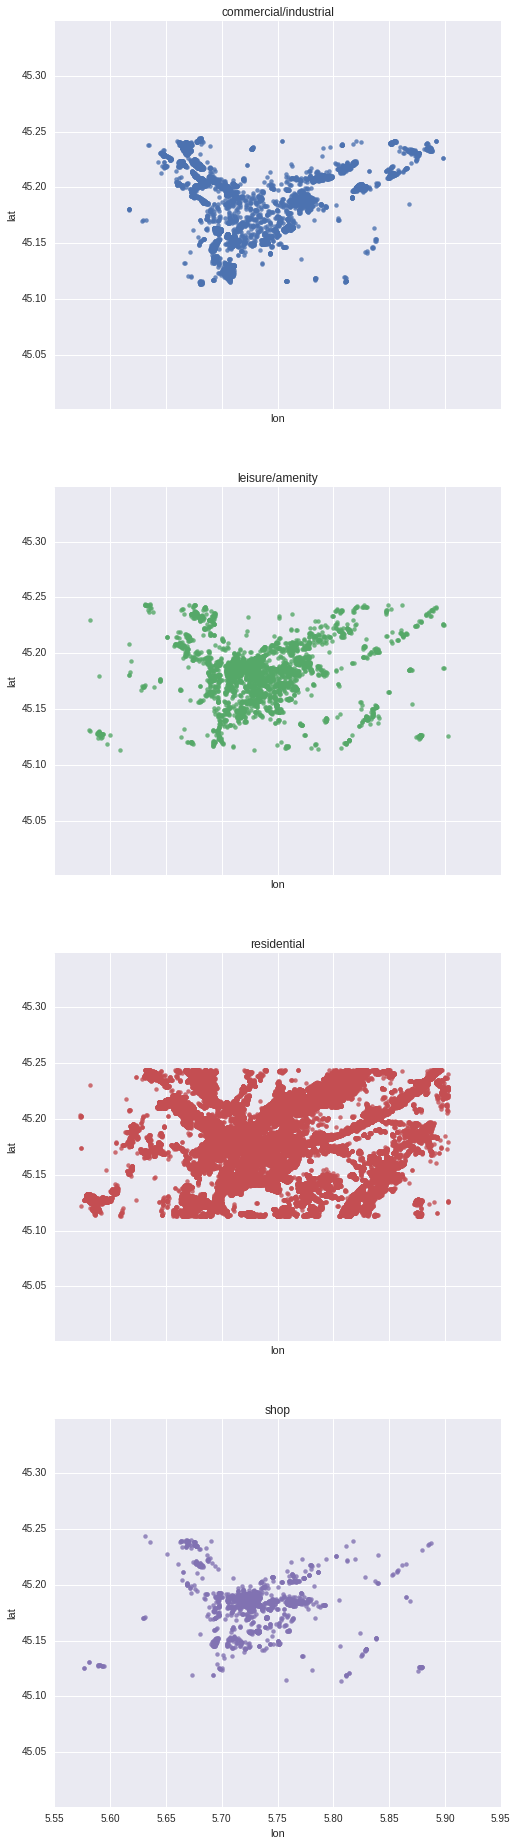

In [58]:
import plots

%matplotlib inline
plots.pois_scatter(pois_df)

In [59]:
kde_df.head()

commercial/industrial  leisure/amenity  residential      shop
501809164              -1.844042        -1.843218    -1.843690 -1.842945
501809165              -1.844193        -1.843366    -1.843812 -1.843104
501809166              -1.844325        -1.843498    -1.843925 -1.843242
501809167              -1.844005        -1.843177    -1.843647 -1.842905
501809168              -1.844196        -1.843367    -1.843812 -1.843106

In [60]:
import pandas as pd

# TODO: automatize this in some module

centrality_kde_df = pd.concat([
    pd.DataFrame({ key: value for (key, value) in zip(kde_df.columns, list(map(kde_df.__getitem__, kde_df.columns))) }),
    centrality_df], axis=1, keys=['kde', 'centrality'])
centrality_kde_df.head()

kde                                        \
       commercial/industrial leisure/amenity residential      shop   
124550             -1.840266       -1.839345   -1.840978 -1.838642   
124551             -1.840241       -1.839323   -1.840944 -1.838624   
124552             -1.840238       -1.839313   -1.840912 -1.838623   
124553             -1.840261       -1.839333   -1.840941 -1.838640   
124554             -1.840509       -1.839563   -1.841265 -1.838836   

        centrality                      
       betweenness closeness    degree  
124550    0.000000  0.012452  0.000191  
124551    0.000048  0.012483  0.000287  
124552    0.002271  0.012540  0.000287  
124553    0.000459  0.012735  0.000287  
124554    0.002521  0.013672  0.000287

In [61]:
# TODO: automatize this in some module
centrality_kde_corr = centrality_kde_df.corr().xs('kde', level=0).xs('centrality', level=0, axis=1)
centrality_kde_corr

betweenness  closeness    degree
commercial/industrial     0.135848   0.591955  0.170344
leisure/amenity           0.136160   0.588780  0.170087
residential               0.135851   0.535570  0.153511
shop                      0.133333   0.594683  0.172131

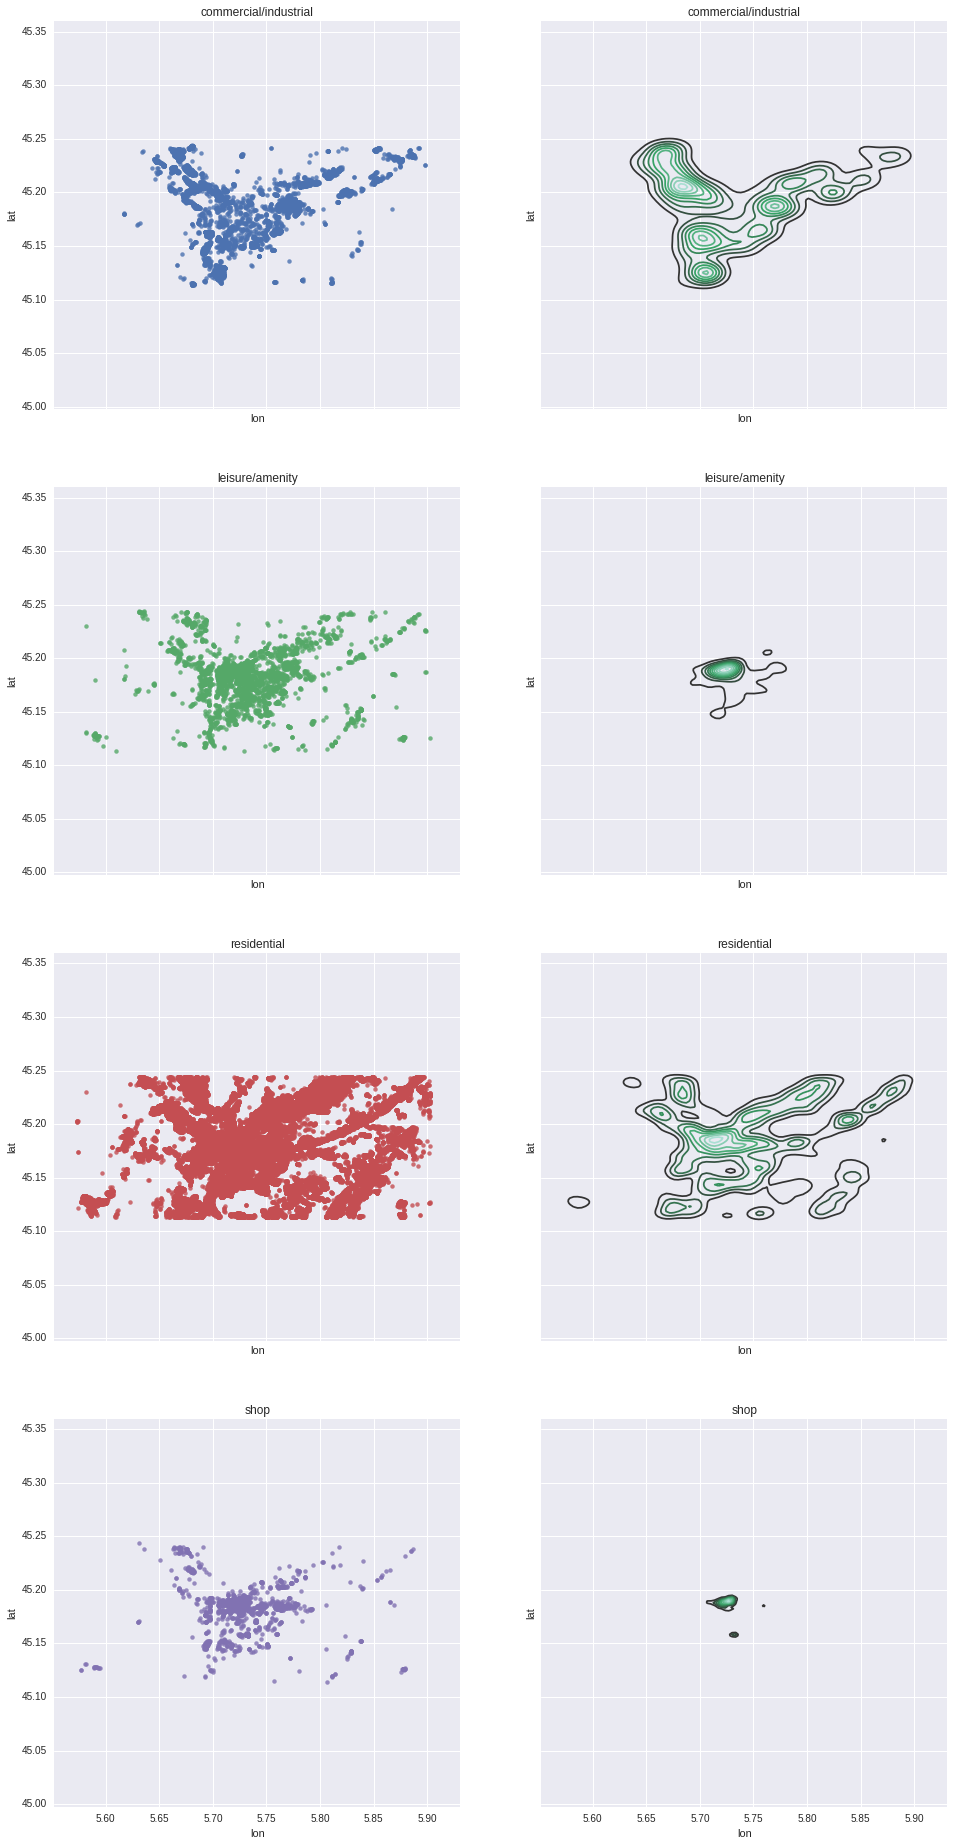

In [65]:
plots.pois_scatter_kde(pois_df)

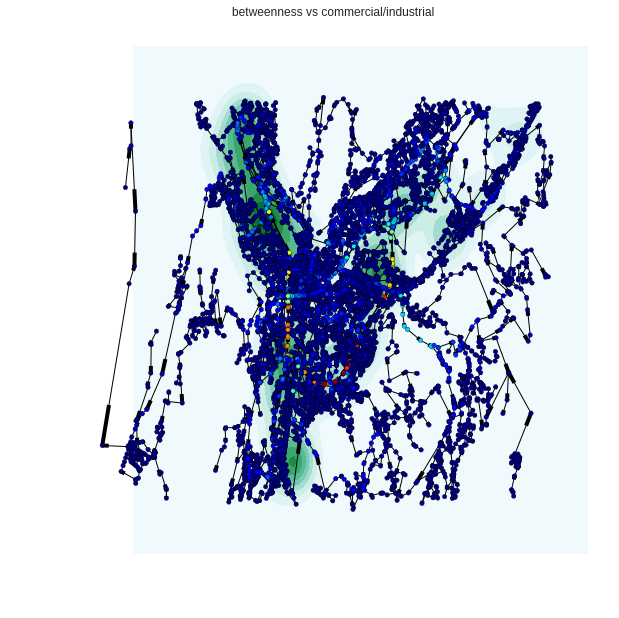

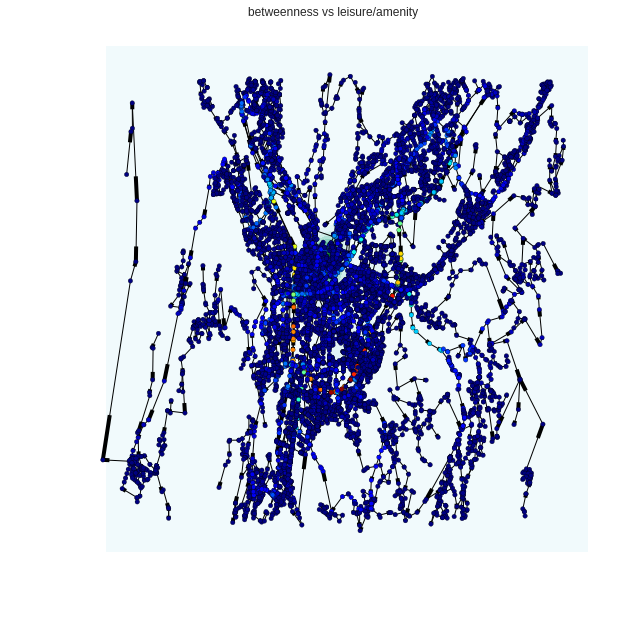

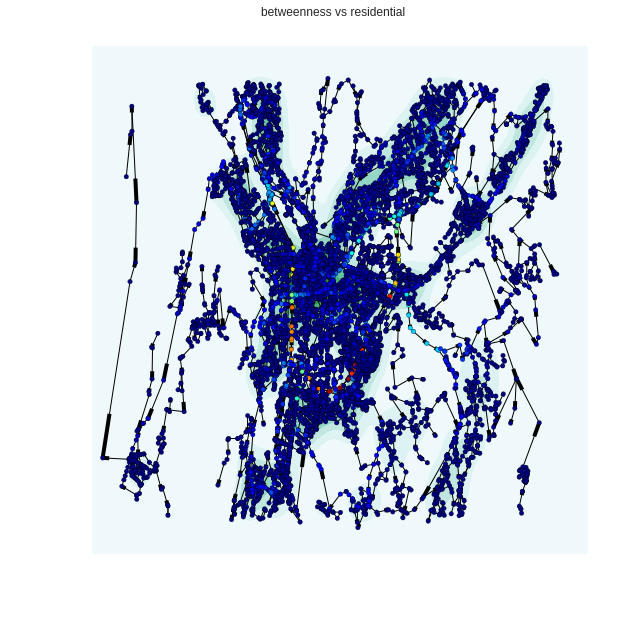

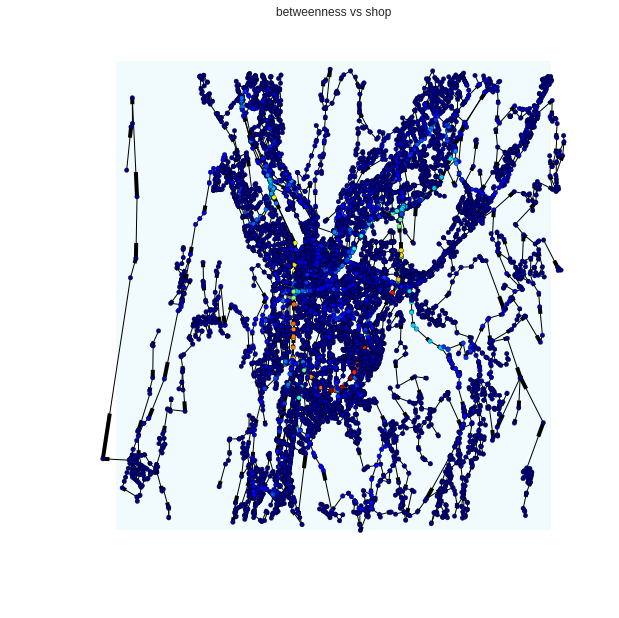

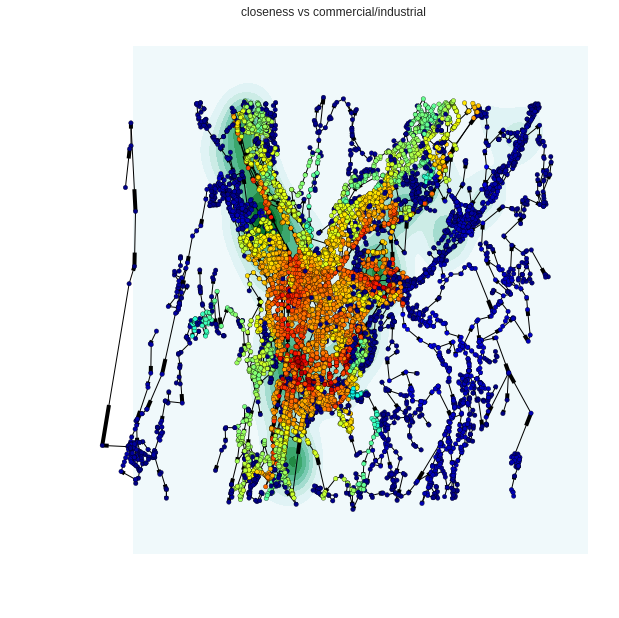

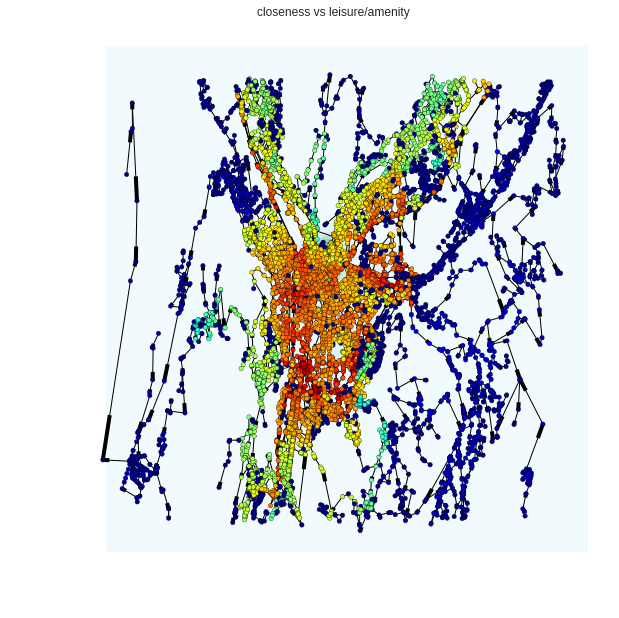

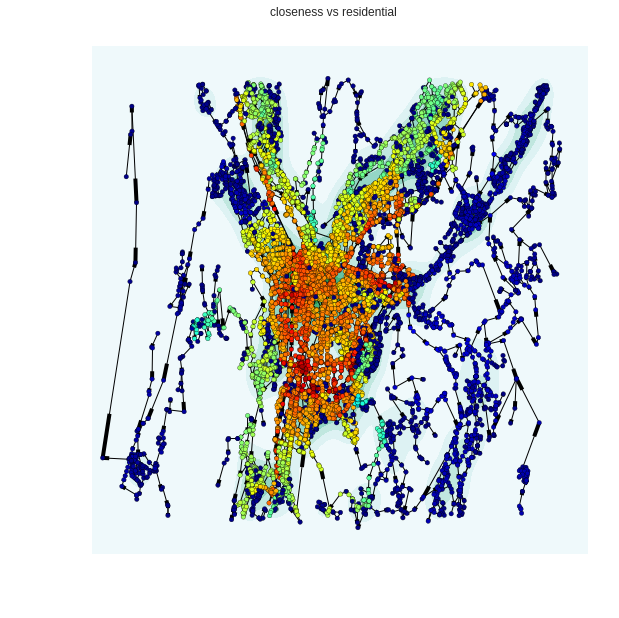

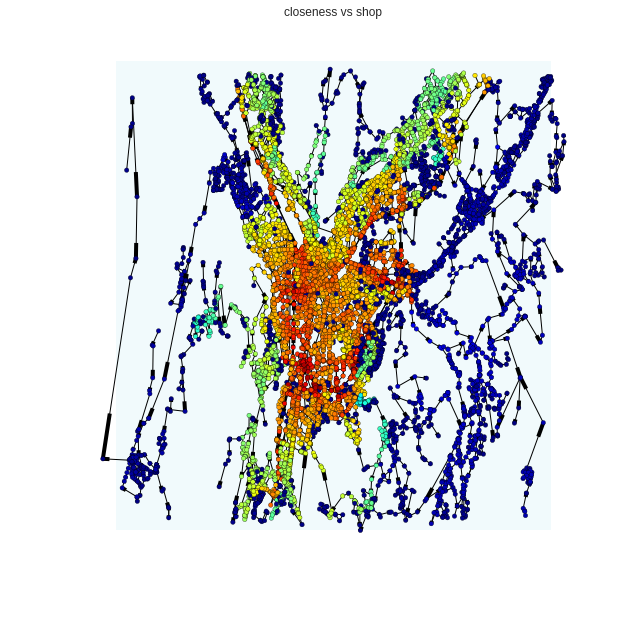

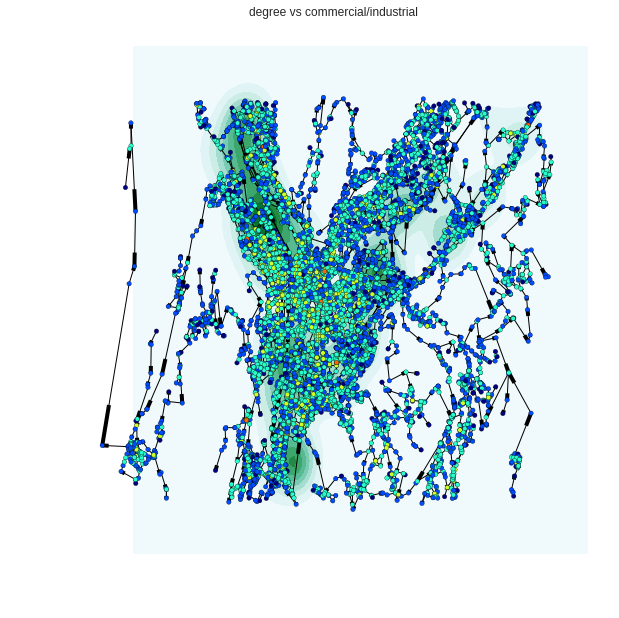

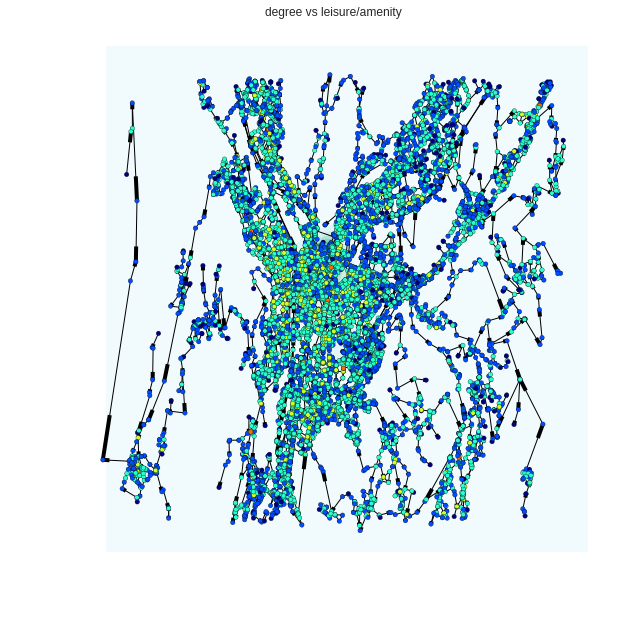

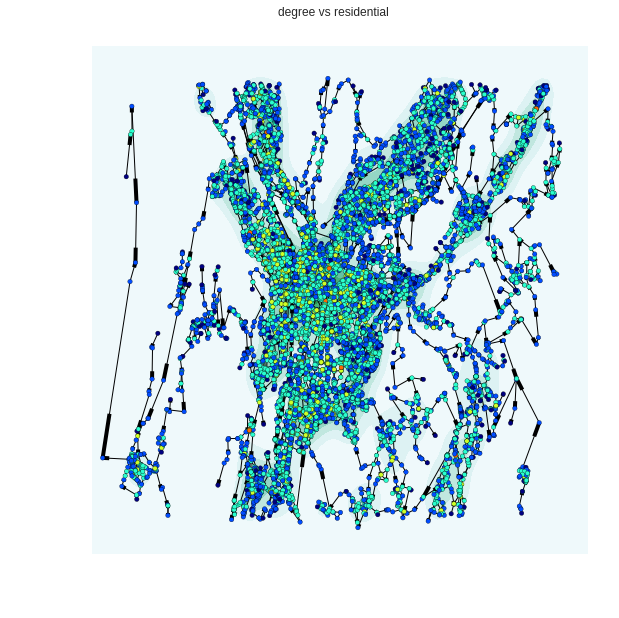

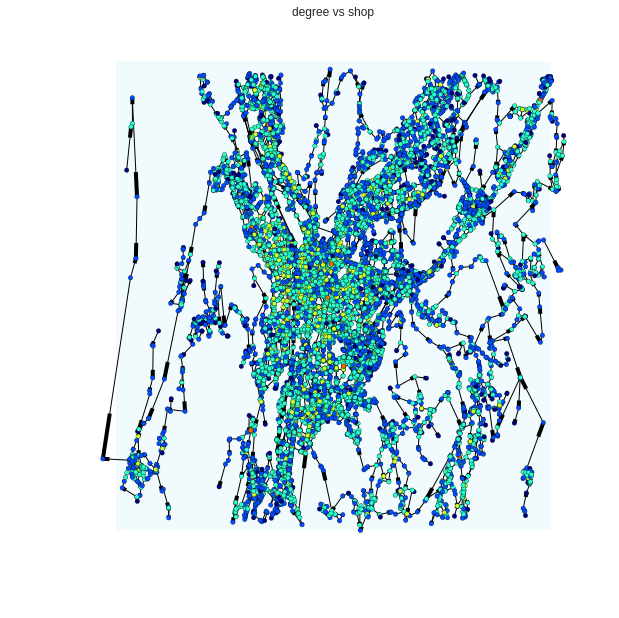

In [66]:
# TODO: create method for this in plots.py
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib qt

cmap = plt.get_cmap('jet')

for centrality_label in centrality_df:
    for category_label, category_ser in pois_df.groupby(by=['category']):
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_title(centrality_label + ' vs ' + category_label)
        sns.kdeplot(category_ser['lon'], category_ser['lat'], ax=ax, legend=True, shade=True)
        geo_graph.plot(ax, node_color = [centrality_df[centrality_label][node.id] for node in geo_graph], node_size=20, cmap=cmap) # TODO: maybe hide edges